In [1]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

In [15]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 10# For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  =100
    activation        = 'elu'
    classification_act= 'linear'
    model_constraint  =  25
    regularization    = 0.1
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 5000
    
    num_networks      = 6
    

In [16]:
import tensorflow as tf
from mat4py import loadmat
import numpy as np
import pandas as pd
from Utilities.plotting_sine import plot_sine
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.NN_FC_layerwise_new import FCLayerwise_new
from Utilities.NETW import Final
from Utilities.Net import Final_Network
from Utilities.Net_new import Final_Network_ALGO_II
from Utilities.create_data import create_new
from Utilities.create_data_multiply import create_new_multiply
from Utilities.L2_error_computation import error_L2
from Utilities.loss_and_accuracies import data_loss_classification, data_loss_regression
from Utilities.manifold_regularization import manifold_classification
from Utilities.model_constraint import compute_interior_loss
from Utilities.model_constraint_weak import compute_interior_loss_weak
from Utilities.manifold_regularization_new import manifold_classification_new
from Utilities.optimize_layerwise import optimize
from Utilities.optimize_step_II import optimize_step
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [17]:
class Hyperparameters_new:
    max_hidden_layers = 3 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 20
    activation        = 'elu'
    classification_act= 'linear'
    regularization    = 0.000
    manifold          = 0.000
    model_constraint  =  60
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 500
    num_epochs        = 5000

In [18]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 0
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        self.data_regression=1
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [19]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if run_options.data_regression == 1:
            self.dataset = 'Abalone'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



In [20]:
if __name__ == "__main__":     

    trainable=6
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    
    gauss_solution=np.loadtxt("gauss_solution.data")
    gauss_solution = tf.cast(gauss_solution,tf.float32)
    
    gauss_points = loadmat('gauss_points.mat')
    gauss_points=np.array(list(gauss_points.values()))[-1]
    gauss_points = tf.cast(gauss_points,tf.float32)
    
    gauss_points_new = loadmat('gauss_points_new.mat')
    gauss_points_new=np.array(list(gauss_points_new.values()))[-1]
    gauss_points_new = tf.cast(gauss_points_new,tf.float32)
    
    gauss_weights = loadmat('gauss_weights.mat')
    gauss_weights=np.array(list(gauss_weights.values()))[-1].squeeze(-1)
    
    gauss_weights_new = loadmat('gauss_weights_new.mat')
    gauss_weights_new=np.array(list(gauss_weights_new.values()))[-1].squeeze(-1)

    
    Coordinates = loadmat('Coordinates.mat')
    Coordinates=np.array(list(Coordinates.values()))[-1]
    Coordinates = tf.cast(Coordinates,tf.float32)
    
    
    Stiffness = loadmat('Stiffness.mat')
    Stiffness=np.array(list(Stiffness.values()))[-1]
    Stiffness = tf.cast(Stiffness,tf.float32)
    
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))
    
    Solution = loadmat('Solution.mat')
    Solution=np.array(list(Solution.values()))[-1]
    Solution=tf.cast(Solution,tf.float32)
    Solution=tf.reshape(Solution,(len(Solution),1))
    
    

    v=[]
    for i in range(0,len(Solution)):
        if np.abs(Solution[i])<1e-10:
            v.append(i)
    
    #for i in range(1,hyperp.num_networks):
    for i in range(1,2):
    #=== Initiate training ===#
        #trainer(hyperp, run_options, file_paths,i) 
        if i>1:
            trainable=2

    
            
        if trainable==2:
        
        
        
            #=== GPU Settings ===#
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
            os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
            if run_options.use_L1 == 0:
                kernel_regularizer = None
                bias_regularizer = None  
            else:
                kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
                bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            
            
            multiply=0
        
            if multiply==0:

                data_train,new_label,labels_train,load,Solution=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i,load,Stiffness,Coordinates,Solution)
        
            if multiply==1:

                data_train,new_label,labels_train=create_new_multiply(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
     
        #=== Construct Validation Set and Batches ===# 
            data_and_labels_train, data_and_labels_val, data_and_labels_test,\
            num_data_train, num_data_val, num_data_test,\
            num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
            = form_train_val_test_batches(data_train, labels_train, \
                                      data_test, labels_test, \
                                      hyperp.batch_size, new_label, run_options.random_seed)
        
        
        if i==1 and trainable==2:
            NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer)    
            NN._set_inputs( data_train)
        if i>1:
            kernel_regularizer = None
            bias_regularizer = None
            NN = FCLayerwise_new(hyperp_new, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer) 
            NN._set_inputs( data_train)
    #=== Training ===#
    #                                 Training                                    #
###############################################################################
        if trainable>2:
            del NN
            NN = Final(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer,trainable)   
            #NN._set_inputs(data_train)
            NN.load_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable-1))
            #NN=tf.keras.models.load_model("WEIGHTS"+'/'+"model"+str(1)+str(trainable-1))
        


        if i==1:
            hyperp_n=hyperp
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,trainable,compute_interior_loss,gauss_points,gauss_weights,error_L2,gauss_solution,gauss_points_new,gauss_weights_new,Coordinates, Stiffness, load,Solution,v)   
        
        if i>1:
            hyperp_n=Hyperparameters_new()
            optimize_step(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, data_loss_regression, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification_new,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape,data_train,labels_train,multiply,compute_interior_loss,gauss_points,gauss_weights,error_L2,gauss_solution,gauss_points_new,gauss_weights_new,Coordinates, Stiffness, load,Solution,v)   
        
        #NN.save("WEIGHTS"+'/'+"model"+str(1)+str(trainable))
        if not os.path.exists("WEIGHTS"):
            os.makedirs("WEIGHTS")
        NN.save_weights("WEIGHTS"+'/'+"model_weights"+str(1)+str(trainable))
        
        if i==1:
            plot_fig(hyperp, run_options, file_paths,i,trainable+1)
            
        if i>1:
            plot_fig(hyperp_new, run_options, file_paths,i,3)
        
        
        #plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,2,data_train, labels_train)
        
   
        
        
        
        
        
        
        
        

ListWrapper([2, 100, 100, 1])
Beginning Training
            Epoch 0            
Abalone_FC_L1_mhl10_hl100_rpt1_nTOL4_eTOL4_b500_e5000
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 10 batches of size 500:
Model: "final_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
W2 (Dense)                   multiple                  10100     
_________________________________________________________________
W3 (Dense)                   multiple                  10100     
_________________________________________________________________
W4 (Dense)                   multiple                  10100     
_________________________________________________________________
W5 (Dense)                   multiple                  10100     
_________________________________________________________________
W6 (Dense)                   multiple                  10100     
_______________________________________________

FileNotFoundError: [Errno 2] No such file or directory: 'Abalone_FC_L1_mhl10_hl100_rpt1_nTOL4_eTOL4_b500_e5000/Abalone_FC_L1_mhl10_hl100_rpt1_nTOL4_eTOL4_b500_e5000_metrics_hl21.csv'

Text(0, 0.5, 'Accuracy')

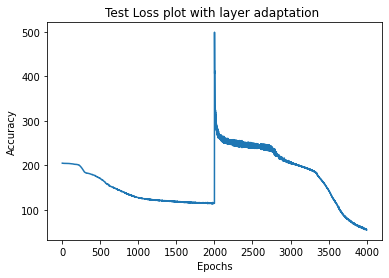

In [82]:
    import matplotlib.pyplot as plt
    
    storage_loss_array=[]
    
    no_epoch=hyperp.num_epochs
    
    for i in range(2,4):
    
        trainable_hidden_layer_index=i
    
    
        name=file_paths.NN_savefile_name + "_metrics_hl" + str(trainable_hidden_layer_index) +str(1)+ '.csv'


        df_metrics =pd.read_csv(name)

        array_metrics = df_metrics.to_numpy()

        
 
        storage_loss_array=np.concatenate((storage_loss_array, array_metrics[:,0]), axis=0)
    
    fig_accuracy = plt.figure()
    x_axis = np.linspace(1, len(storage_loss_array), len(storage_loss_array), endpoint = True)
    plt.plot(x_axis, storage_loss_array)
    #plt.ylim(-5, 60)

#plt.title('Accuracy for: ' + run_options.filename)
    plt.title('Test Loss plot with layer adaptation ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')


In [10]:
data_train

<tf.Tensor: id=16693, shape=(5000, 2), dtype=float32, numpy=
array([[0.696799  , 0.5       ],
       [0.        , 0.15995109],
       [0.74418575, 0.5       ],
       ...,
       [0.5982862 , 0.5       ],
       [0.        , 0.6563306 ],
       [1.        , 0.18497042]], dtype=float32)>

In [12]:
tf.math.reduce_sum(tf.keras.losses.MSE(Solution, pred))

<tf.Tensor: id=6744890, shape=(), dtype=float32, numpy=178.8639>

In [22]:
G=tf.linalg.inv(Stiffness)

KeyboardInterrupt: 

In [28]:
    trainable=2
    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed)               
    
 

In [14]:
len(data_train)

4000

<Figure size 432x288 with 0 Axes>

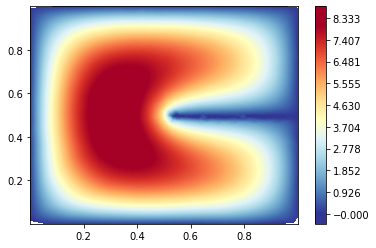

In [14]:
plot_sine(hyperp,hyperp_new, data_test, run_options, data_input_shape, label_dimensions,2,data_train, labels_train,labels_test)
        

In [8]:
labels_train

array([3, 0, 3, ..., 4, 1, 0], dtype=int32)

In [15]:
    Coordinates = loadmat('Coordinates.mat')
    Coordinates=np.array(list(Coordinates.values()))[-1]
    Coordinates = tf.cast(Coordinates,tf.float32)
    
    
    Stiffness = loadmat('Stiffness.mat')
    Stiffness=np.array(list(Stiffness.values()))[-1]
    Stiffness = tf.cast(Stiffness,tf.float32)
    
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))

In [17]:
    solution = loadmat('Solution.mat')
    solution=np.array(list(solution.values()))[-1]
    solution=tf.cast(solution,tf.float32)
    solution=tf.reshape(solution,(len(solution),1))

In [20]:
tf.math.reduce_sum(tf.keras.losses.MSE(load, loss))

<tf.Tensor: id=5127044, shape=(), dtype=float32, numpy=2.9658818e-09>

In [9]:
loss=tf.matmul(Stiffness, Solution)

In [12]:
        #loss=tf.matmul(Stiffness, pred)
        pred,new = NN(Coordinates)
        X=tf.matmul(tf.transpose(pred-Solution),tf.transpose(Stiffness))
        Y=tf.matmul(X,Stiffness)
        Z=tf.matmul(Y,pred-Solution)

In [13]:
Z

<tf.Tensor: id=7178056, shape=(1, 1), dtype=float32, numpy=array([[251.45015]], dtype=float32)>

In [11]:
import mat4py as m4p
bb=list(loss)
load = {'x': bb}
m4p.savemat('observation.mat', load)

ValueError: Only dicts, two dimensional numeric, and char arrays are currently supported

In [13]:
loss_final=tf.math.reduce_sum(loss_new)

In [17]:
pred,l=NN(Coordinates )

In [18]:
pred

<tf.Tensor: id=17715, shape=(961, 1), dtype=float32, numpy=
array([[0.9965409 ],
       [0.97466844],
       [1.016253  ],
       [0.95278144],
       [0.9943896 ],
       [1.0359524 ],
       [0.9308796 ],
       [0.97251153],
       [1.0140978 ],
       [1.0556387 ],
       [0.90896285],
       [0.9506185 ],
       [0.99222857],
       [1.0337929 ],
       [1.0753115 ],
       [0.8870313 ],
       [0.9287108 ],
       [0.9703443 ],
       [1.0119323 ],
       [1.0534745 ],
       [1.0949715 ],
       [0.8650848 ],
       [0.9067881 ],
       [0.94844544],
       [0.9900569 ],
       [1.0316228 ],
       [1.0731431 ],
       [1.1146182 ],
       [0.8431233 ],
       [0.88485044],
       [0.92653155],
       [0.9681667 ],
       [1.0097562 ],
       [1.0513002 ],
       [1.0927986 ],
       [1.1342517 ],
       [0.82114685],
       [0.8628979 ],
       [0.90460277],
       [0.94626164],
       [0.98787487],
       [1.0294422 ],
       [1.0709642 ],
       [1.1124408 ],
       [1.153872

In [13]:
len(Solution)

2601

In [7]:
    load = loadmat('observation.mat')
    load=np.array(list(load.values()))[-1]
    load=tf.cast(load,tf.float32)
    load=tf.reshape(load,(len(load),1))

In [8]:
len(load)

961